# Importing and Installing all necessary libraries

In [ ]:
!pip install pyspark

!apt-get install openjdk-8-jdk-headless -qq > /dev/null

!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
!tar xf spark-3.2.1-bin-hadoop2.7.tgz

!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"

from pyspark.sql import functions as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql.window import Window
# from pyspark.sql.functions import * #lot of functions available here
from pyspark.sql.types import IntegerType, StringType
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import col, log, isnan, count
from pyspark.ml.feature import Imputer
import pyspark.ml.regression as mlr
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline

import warnings
warnings.simplefilter(action='ignore')

from pyspark.sql import SparkSession
from pyspark.sql.types import *
spark = SparkSession.builder.appName("Car_Sales").getOrCreate()
spark

     |████████████████████████████████| 281.4 MB 35 kB/s 
     |████████████████████████████████| 198 kB 61.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=c16a2f3dd7bfc8de85713bbb940d1fd4000cc6d794a64ec1e2365c4e1b1342ab
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


# Importing Data

In [ ]:
df = spark.read.format("csv").option("header",True).option("inferSchema",True).load("/content/drive/MyDrive/Car_sales.csv")

In [ ]:
df.printSchema()

root
 |-- Manufacturer: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Sales_in_thousands: double (nullable = true)
 |-- four_year_resale_value: double (nullable = true)
 |-- Vehicle_type: string (nullable = true)
 |-- Price_in_thousands: double (nullable = true)
 |-- Engine_size: double (nullable = true)
 |-- Horsepower: integer (nullable = true)
 |-- Wheelbase: double (nullable = true)
 |-- Width: double (nullable = true)
 |-- Length: double (nullable = true)
 |-- Curb_weight: double (nullable = true)
 |-- Fuel_capacity: double (nullable = true)
 |-- Fuel_efficiency: integer (nullable = true)
 |-- Latest_Launch: string (nullable = true)
 |-- Power_perf_factor: double (nullable = true)



In [ ]:
df.show(5)

+------------+-------+------------------+----------------------+------------+------------------+-----------+----------+---------+-----+------+-----------+-------------+---------------+-------------+-----------------+
|Manufacturer|  Model|Sales_in_thousands|four_year_resale_value|Vehicle_type|Price_in_thousands|Engine_size|Horsepower|Wheelbase|Width|Length|Curb_weight|Fuel_capacity|Fuel_efficiency|Latest_Launch|Power_perf_factor|
+------------+-------+------------------+----------------------+------------+------------------+-----------+----------+---------+-----+------+-----------+-------------+---------------+-------------+-----------------+
|       Acura|Integra|            16.919|                 16.36|   Passenger|              21.5|        1.8|       140|    101.2| 67.3| 172.4|      2.639|         13.2|             28|     2/2/2012|      58.28014952|
|       Acura|     TL|            39.384|                19.875|   Passenger|              28.4|        3.2|       225|    108.1| 70

## Handling Missing Values

In [ ]:
df.select([count(F.when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------------+-----+------------------+----------------------+------------+------------------+-----------+----------+---------+-----+------+-----------+-------------+---------------+-------------+-----------------+
|Manufacturer|Model|Sales_in_thousands|four_year_resale_value|Vehicle_type|Price_in_thousands|Engine_size|Horsepower|Wheelbase|Width|Length|Curb_weight|Fuel_capacity|Fuel_efficiency|Latest_Launch|Power_perf_factor|
+------------+-----+------------------+----------------------+------------+------------------+-----------+----------+---------+-----+------+-----------+-------------+---------------+-------------+-----------------+
|           0|    0|                 0|                    36|           0|                 2|          1|         1|        1|    1|     1|          2|            1|              3|            0|                2|
+------------+-----+------------------+----------------------+------------+------------------+-----------+----------+---------+-----+------+

In [ ]:
input_col = ["four_year_resale_value",
                     "Price_in_thousands",
                     "Horsepower",
                     "Wheelbase",
                     "Width",
                     "Length",
                     "Curb_weight",
                     "Fuel_capacity",
                     "Fuel_efficiency",
                     "Power_perf_factor"]

out_col = ['Out_four_year_resale_value',
                     'Out_Price_in_thousands',
                     'Out_Horsepower',
                     'Out_Wheelbase',
                     'Out_Width',
                     'Out_Length',
                     'Out_Curb_weight',
                     'Out_Fuel_capacity',
                     'Out_Fuel_efficiency',
                     'Out_Power_perf_factor']


imputer1 = Imputer(strategy = 'mean', inputCols= input_col, outputCols= input_col)
newdf = imputer1.fit(df)
newdf.surrogateDF
newdf = newdf.transform(df)
newdf.show()

+------------+-----------+------------------+----------------------+------------+------------------+-----------+----------+---------+-----+------+-----------------+-------------+---------------+-------------+-----------------+
|Manufacturer|      Model|Sales_in_thousands|four_year_resale_value|Vehicle_type|Price_in_thousands|Engine_size|Horsepower|Wheelbase|Width|Length|      Curb_weight|Fuel_capacity|Fuel_efficiency|Latest_Launch|Power_perf_factor|
+------------+-----------+------------------+----------------------+------------+------------------+-----------+----------+---------+-----+------+-----------------+-------------+---------------+-------------+-----------------+
|       Acura|    Integra|            16.919|                 16.36|   Passenger|              21.5|        1.8|       140|    101.2| 67.3| 172.4|            2.639|         13.2|             28|     2/2/2012|      58.28014952|
|       Acura|         TL|            39.384|                19.875|   Passenger|           

## Visualizing data for future transformation

[]

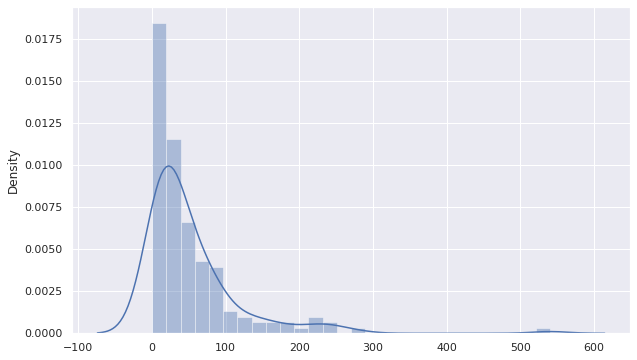

In [ ]:
sns.set(rc={"figure.figsize": (10, 6)})
sns.distplot(newdf.select('Sales_in_thousands').toPandas(), norm_hist=True)
plt.plot()

[]

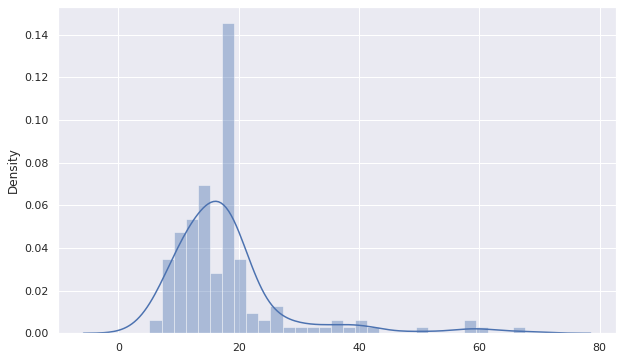

In [ ]:
sns.distplot(newdf.select('four_year_resale_value').toPandas(), norm_hist=True)
plt.plot()

[]

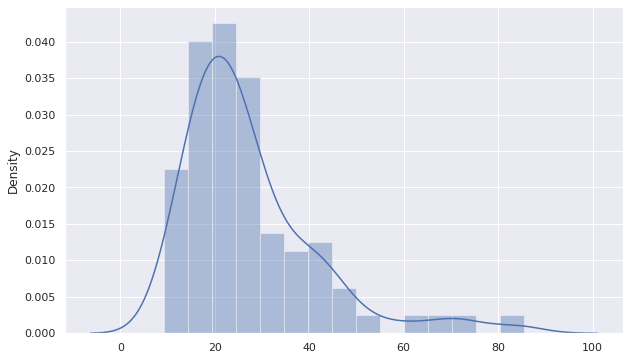

In [ ]:
sns.distplot(newdf.select('Price_in_thousands').toPandas(), norm_hist=True)
plt.plot()

[]

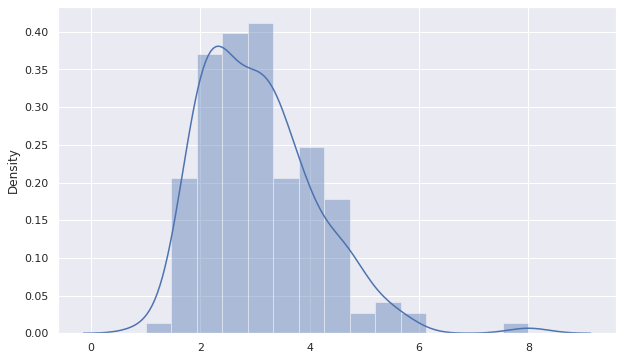

In [ ]:
sns.distplot(newdf.select('Engine_size').toPandas(), norm_hist=True)
plt.plot()

[]

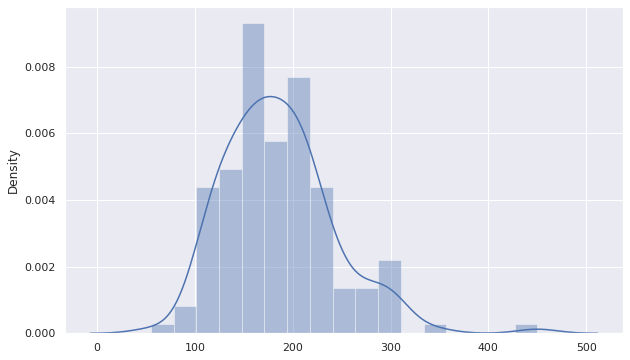

In [ ]:
sns.distplot(newdf.select('Horsepower').toPandas(), norm_hist=True)
plt.plot()

[]

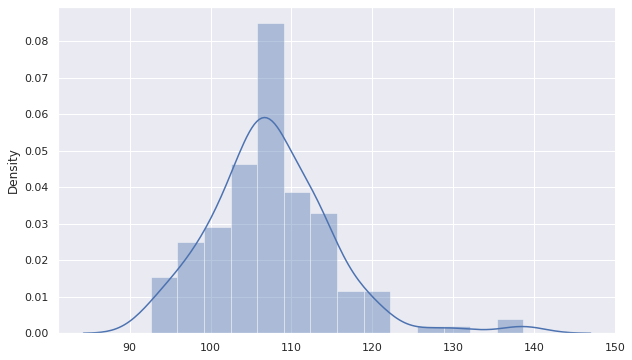

In [ ]:
sns.distplot(newdf.select('Wheelbase').toPandas(), norm_hist=True)
plt.plot()

[]

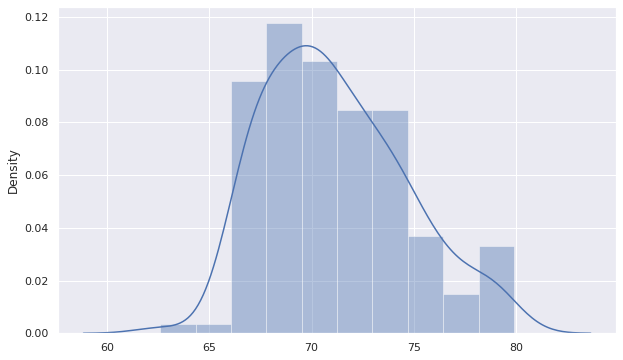

In [ ]:
sns.distplot(newdf.select('Width').toPandas(), norm_hist=True)
plt.plot()

[]

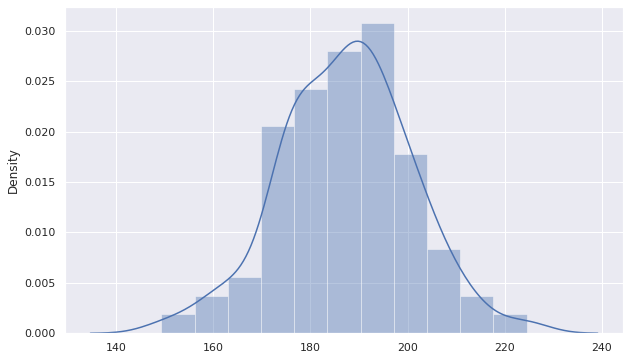

In [ ]:
sns.distplot(newdf.select('Length').toPandas(), norm_hist=True)
plt.plot()

[]

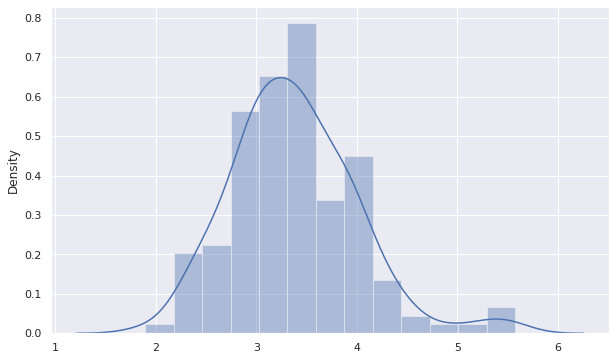

In [ ]:
sns.distplot(newdf.select('Curb_weight').toPandas(), norm_hist=True)
plt.plot()

[]

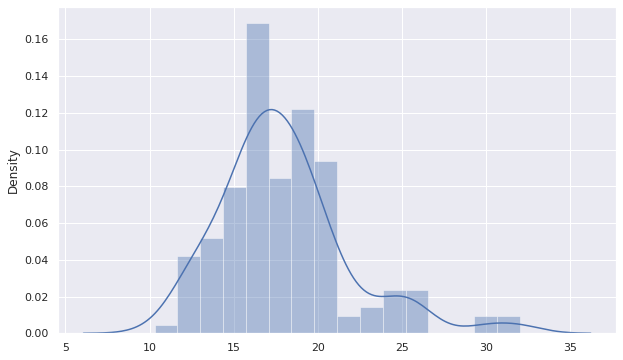

In [ ]:
sns.distplot(newdf.select('Fuel_capacity').toPandas(), norm_hist=True)
plt.plot()

[]

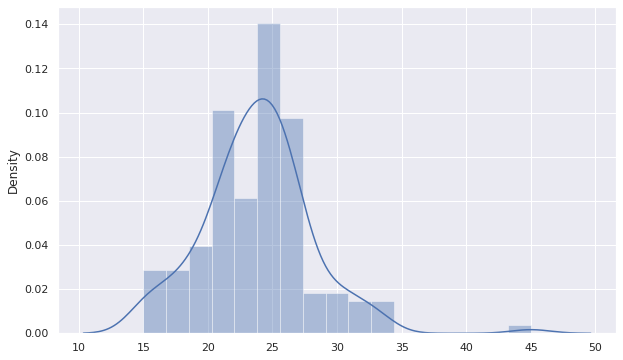

In [ ]:
sns.distplot(newdf.select('Fuel_efficiency').toPandas(), norm_hist=True)
plt.plot()

[]

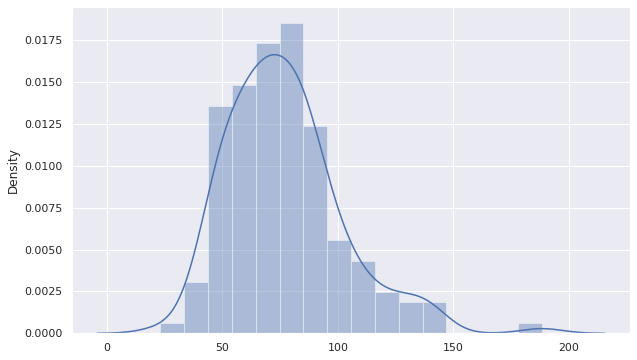

In [ ]:
sns.distplot(newdf.select('Power_perf_factor').toPandas(), norm_hist=True)
plt.plot()

From the visualizations we can conclude that columns - Sales_in_thousands, four_year_resale_valu, Price_in_thousands and Horsepower needs transformation

In [ ]:
for col in newdf.columns:
  if col != 'Manufacturer' and col != 'Model' and col != 'Vehicle_type' and col != 'Latest_Launch' :
    print(col)

Sales_in_thousands
four_year_resale_value
Price_in_thousands
Engine_size
Horsepower
Wheelbase
Width
Length
Curb_weight
Fuel_capacity
Fuel_efficiency
Power_perf_factor


In [ ]:
# fig, axes = plt.subplots(ncols=len(newdf.columns), figsize=(80,40))
# for ax, col in zip(axes, newdf.columns):
#   if col != 'Manufacturer' and col != 'Model' and col != 'Vehicle_type' and col != 'Latest_Launch' :
#     sns.distplot(newdf.select(col).toPandas(), norm_hist=True, ax=ax)
#     plt.suptitle(str(col))
#     plt.tight_layout() 
# plt.show()

# String Indexer

In [ ]:
newdf.show(5)

+------------+-------+------------------+----------------------+------------+------------------+-----------+----------+---------+-----+------+-----------+-------------+---------------+-------------+-----------------+
|Manufacturer|  Model|Sales_in_thousands|four_year_resale_value|Vehicle_type|Price_in_thousands|Engine_size|Horsepower|Wheelbase|Width|Length|Curb_weight|Fuel_capacity|Fuel_efficiency|Latest_Launch|Power_perf_factor|
+------------+-------+------------------+----------------------+------------+------------------+-----------+----------+---------+-----+------+-----------+-------------+---------------+-------------+-----------------+
|       Acura|Integra|            16.919|                 16.36|   Passenger|              21.5|        1.8|       140|    101.2| 67.3| 172.4|      2.639|         13.2|             28|     2/2/2012|      58.28014952|
|       Acura|     TL|            39.384|                19.875|   Passenger|              28.4|        3.2|       225|    108.1| 70

In [ ]:
print('Manufacturer',newdf.select('Manufacturer').distinct().show())
print('Number of manufacturers',newdf.select('Manufacturer').distinct().count())

+------------+
|Manufacturer|
+------------+
|  Volkswagen|
|  Oldsmobile|
|    Infiniti|
|       Lexus|
|      Jaguar|
|      Saturn|
|        Jeep|
|  Mitsubishi|
|   Chevrolet|
|       Volvo|
|     Hyundai|
|        Saab|
|       Honda|
|        Audi|
|    Cadillac|
|    Plymouth|
|     Pontiac|
|     Mercury|
|    Chrysler|
|     Lincoln|
+------------+
only showing top 20 rows

Manufacturer None
Number of manufacturers 30


In [ ]:
print('Model',newdf.select('Model').distinct().show())
print('Number of distinct models',newdf.select('Model').distinct().count())

+-------------+
|        Model|
+-------------+
|       Cirrus|
|      Contour|
|        RX300|
|     Villager|
|           SC|
|      Cutlass|
|           SL|
|        Camry|
|      Seville|
|    Ram Wagon|
|      Outback|
|         300M|
|           A6|
|Grand Marquis|
|         Golf|
|     Forester|
|       Sentra|
|     Cherokee|
|        Focus|
|     Wrangler|
+-------------+
only showing top 20 rows

Model None
Number of distinct models 156


In [ ]:
# dropping Model column as there are number of distinct models are 156 which shall hinder Regression Modelling
newdf = newdf.drop('Model')
newdf.show(5)

+------------+------------------+----------------------+------------+------------------+-----------+----------+---------+-----+------+-----------+-------------+---------------+-------------+-----------------+
|Manufacturer|Sales_in_thousands|four_year_resale_value|Vehicle_type|Price_in_thousands|Engine_size|Horsepower|Wheelbase|Width|Length|Curb_weight|Fuel_capacity|Fuel_efficiency|Latest_Launch|Power_perf_factor|
+------------+------------------+----------------------+------------+------------------+-----------+----------+---------+-----+------+-----------+-------------+---------------+-------------+-----------------+
|       Acura|            16.919|                 16.36|   Passenger|              21.5|        1.8|       140|    101.2| 67.3| 172.4|      2.639|         13.2|             28|     2/2/2012|      58.28014952|
|       Acura|            39.384|                19.875|   Passenger|              28.4|        3.2|       225|    108.1| 70.3| 192.9|      3.517|         17.2|    

In [ ]:
print('Vehicle_type',newdf.select('Vehicle_type').distinct().show())
print('Number of vehicle types:',newdf.select('Vehicle_type').distinct().count())

+------------+
|Vehicle_type|
+------------+
|         Car|
|   Passenger|
+------------+

Vehicle_type None
Number of vehicle types: 2


In [ ]:
input_col = ["Manufacturer",
                     "Vehicle_type",]

out_col = ["Indexed_Manufacturer",
                     "Indexed_Vehicle_type",]

In [ ]:
indexer = StringIndexer(inputCols=input_col, outputCols=out_col) 
indexed = indexer.fit(newdf).transform(newdf) 
indexed.show()

+------------+------------------+----------------------+------------+------------------+-----------+----------+---------+-----+------+-----------------+-------------+---------------+-------------+-----------------+--------------------+--------------------+
|Manufacturer|Sales_in_thousands|four_year_resale_value|Vehicle_type|Price_in_thousands|Engine_size|Horsepower|Wheelbase|Width|Length|      Curb_weight|Fuel_capacity|Fuel_efficiency|Latest_Launch|Power_perf_factor|Indexed_Manufacturer|Indexed_Vehicle_type|
+------------+------------------+----------------------+------------+------------------+-----------+----------+---------+-----+------+-----------------+-------------+---------------+-------------+-----------------+--------------------+--------------------+
|       Acura|            16.919|                 16.36|   Passenger|              21.5|        1.8|       140|    101.2| 67.3| 172.4|            2.639|         13.2|             28|     2/2/2012|      58.28014952|               

In [ ]:
print('Manufacturer',indexed.select('Manufacturer').distinct().count(), 'Indexed_Manufacturer',indexed.select('Indexed_Manufacturer').distinct().count())

Manufacturer 30 Indexed_Manufacturer 30


In [ ]:
print('Vehicle_type',indexed.select('Vehicle_type').distinct().count(), 'Indexed_Vehicle_type',indexed.select('Indexed_Vehicle_type').distinct().count())

Vehicle_type 2 Indexed_Vehicle_type 2


In [ ]:
indexed = indexed.withColumn('label', log('Sales_in_thousands'))
indexed = indexed.withColumn('four_year_resale_value', log('four_year_resale_value'))
indexed = indexed.withColumn('Price_in_thousands', log('Price_in_thousands'))
indexed = indexed.withColumn('Engine_size', log('Engine_size'))

In [ ]:
indexed.columns

['Manufacturer',
 'Sales_in_thousands',
 'four_year_resale_value',
 'Vehicle_type',
 'Price_in_thousands',
 'Engine_size',
 'Horsepower',
 'Wheelbase',
 'Width',
 'Length',
 'Curb_weight',
 'Fuel_capacity',
 'Fuel_efficiency',
 'Latest_Launch',
 'Power_perf_factor',
 'Indexed_Manufacturer',
 'Indexed_Vehicle_type',
 'label']

In [ ]:
indexed = indexed.dropna()

In [ ]:
indexed.select([count(F.when(isnan(c), c)).alias(c) for c in indexed.columns]).show()

+------------+------------------+----------------------+------------+------------------+-----------+----------+---------+-----+------+-----------+-------------+---------------+-------------+-----------------+--------------------+--------------------+-----+
|Manufacturer|Sales_in_thousands|four_year_resale_value|Vehicle_type|Price_in_thousands|Engine_size|Horsepower|Wheelbase|Width|Length|Curb_weight|Fuel_capacity|Fuel_efficiency|Latest_Launch|Power_perf_factor|Indexed_Manufacturer|Indexed_Vehicle_type|label|
+------------+------------------+----------------------+------------+------------------+-----------+----------+---------+-----+------+-----------+-------------+---------------+-------------+-----------------+--------------------+--------------------+-----+
|           0|                 0|                     0|           0|                 0|          0|         0|        0|    0|     0|          0|            0|              0|            0|                0|                   0|

# Vector Assembler

In [ ]:
assembler = VectorAssembler(inputCols = ['Indexed_Manufacturer',
 'Indexed_Vehicle_type',
 'four_year_resale_value',
 'Price_in_thousands',
 'Engine_size',
 'Horsepower',
 'Wheelbase',
 'Width',
 'Length',
 'Curb_weight',
 'Fuel_capacity',
 'Fuel_efficiency',
 'Power_perf_factor',
], outputCol = "features")

In [ ]:
data = assembler.transform(indexed).select('label','features')
data.show(10)

+------------------+--------------------+
|             label|            features|
+------------------+--------------------+
| 2.828437250776659|[17.0,0.0,2.79483...|
|3.6733596424558996|[17.0,0.0,2.98946...|
|2.6471672125786387|[17.0,0.0,2.90279...|
|2.1503658800165346|[17.0,0.0,3.39198...|
|3.0153878312124323|[20.0,0.0,3.10256...|
| 2.932792473780117|[20.0,0.0,3.15933...|
|0.3220834991691133|[20.0,0.0,3.66356...|
|2.9830015810751727|[21.0,0.0,2.89441...|
|2.2225673850080145|[21.0,0.0,3.35602...|
| 2.863742549091039|[21.0,0.0,3.58698...|
+------------------+--------------------+
only showing top 10 rows



# Train Test Split

In [ ]:
newdf = data.toDF('label','features')
newdf.show(5)

+------------------+--------------------+
|             label|            features|
+------------------+--------------------+
| 2.828437250776659|[17.0,0.0,2.79483...|
|3.6733596424558996|[17.0,0.0,2.98946...|
|2.6471672125786387|[17.0,0.0,2.90279...|
|2.1503658800165346|[17.0,0.0,3.39198...|
|3.0153878312124323|[20.0,0.0,3.10256...|
+------------------+--------------------+
only showing top 5 rows



In [ ]:
train_df, test_df = newdf.randomSplit( [0.7, 0.3], seed = 42 )

# Model Building

## Linear Regression

In [ ]:
LR_model = mlr.LinearRegression()
LR_model = LR_model.fit(train_df)

In [ ]:
pred = LR_model.transform(test_df)
pred.show()

+--------------------+--------------------+------------------+
|               label|            features|        prediction|
+--------------------+--------------------+------------------+
|-0.04709160753385057|[3.0,0.0,2.894417...|0.8701136197663883|
| 0.42264993286226527|[3.0,0.0,2.894417...|1.8194165317368776|
|  0.6270073780554004|[19.0,0.0,2.89441...|3.4500631623463454|
|  1.1972502585651092|[3.0,0.0,4.070734...|0.5356704035266153|
|  1.5547705110917922|[0.0,0.0,2.529322...|3.0561368788327243|
|  1.6530719494541617|[16.0,0.0,2.37861...| 3.975332682734347|
|  1.6563214983329508|[19.0,0.0,2.28238...|3.6123433232497835|
|  1.8773253575577016|[14.0,0.0,3.24746...| 2.658940781954537|
|   2.079191510424627|[3.0,0.0,2.894417...| 1.630158581671643|
|  2.1503658800165346|[17.0,0.0,3.39198...|3.0585786916005917|
|   2.195222574665546|[25.0,0.0,3.71965...| 1.051006723927756|
|   2.258528706797126|[12.0,0.0,2.80789...|3.1812888454958834|
|   2.278394854192828|[12.0,0.0,2.43580...|3.3974964743

In [ ]:
dir(LR_model.summary)

['__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_call_java',
 '_create_from_java_class',
 '_java_obj',
 '_new_java_array',
 '_new_java_obj',
 'coefficientStandardErrors',
 'degreesOfFreedom',
 'devianceResiduals',
 'explainedVariance',
 'featuresCol',
 'labelCol',
 'meanAbsoluteError',
 'meanSquaredError',
 'numInstances',
 'objectiveHistory',
 'pValues',
 'predictionCol',
 'predictions',
 'r2',
 'r2adj',
 'residuals',
 'rootMeanSquaredError',
 'tValues',
 'totalIterations']

In [ ]:
print('MSE: ', LR_model.summary.meanSquaredError)
print('r2 score: ', LR_model.summary.r2)

MSE:  0.898912103619674
r2 score:  0.49475347344211307


## Random Forest Regression

In [ ]:
rfModel = mlr.RandomForestRegressor(featuresCol="features",
                              labelCol="label",
                              numTrees=50,
                              maxDepth=5,
                              featureSubsetStrategy='onethird')

In [ ]:
rflm = rfModel.fit( train_df )

In [ ]:
pred2 = rflm.transform(test_df)
pred2.show()

+--------------------+--------------------+------------------+
|               label|            features|        prediction|
+--------------------+--------------------+------------------+
|-0.04709160753385057|[3.0,0.0,2.894417...| 1.902899150272125|
| 0.42264993286226527|[3.0,0.0,2.894417...|2.1463913719453265|
|  0.6270073780554004|[19.0,0.0,2.89441...| 3.124583510922231|
|  1.1972502585651092|[3.0,0.0,4.070734...| 1.254099385965387|
|  1.5547705110917922|[0.0,0.0,2.529322...|  4.16643889616184|
|  1.6530719494541617|[16.0,0.0,2.37861...| 3.761033834505304|
|  1.6563214983329508|[19.0,0.0,2.28238...|3.8064990868872433|
|  1.8773253575577016|[14.0,0.0,3.24746...|3.2855615566415945|
|   2.079191510424627|[3.0,0.0,2.894417...|2.1944223758177994|
|  2.1503658800165346|[17.0,0.0,3.39198...|3.3667634661152697|
|   2.195222574665546|[25.0,0.0,3.71965...|2.6482351156856305|
|   2.258528706797126|[12.0,0.0,2.80789...|3.3356382972973533|
|   2.278394854192828|[12.0,0.0,2.43580...| 3.519141239

In [ ]:
def get_r2_rmse( model, test_df ):
  y_pred = model.transform( test_df )
  y_pred = y_pred.withColumn( "y_pred", F.exp( 'prediction' ) )
  rmse_evaluator = RegressionEvaluator(labelCol="label",
                              predictionCol="y_pred",
                              metricName="rmse" )
  r2_evaluator = RegressionEvaluator(labelCol="label",
                              predictionCol="y_pred",
                              metricName="r2" )

  return [np.round( r2_evaluator.evaluate( y_pred ), 2), np.round( rmse_evaluator.evaluate( y_pred ), 2 )]

In [ ]:
rf_perf = get_r2_rmse( rflm, test_df )

In [ ]:
print('r2:', rf_perf[0], '\nRMSE:', rf_perf[1])

r2: -1066.93 
RMSE: 40.07


Based on the above results, the best model to use is <b>Linear Regression<b>.

# Pipeline

## Data preparation

In [ ]:
df_2 = spark.read.format("csv").option("header",True).option("inferSchema",True).load("/content/drive/MyDrive/Car_sales.csv")
df_2.printSchema()

root
 |-- Manufacturer: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Sales_in_thousands: double (nullable = true)
 |-- four_year_resale_value: double (nullable = true)
 |-- Vehicle_type: string (nullable = true)
 |-- Price_in_thousands: double (nullable = true)
 |-- Engine_size: double (nullable = true)
 |-- Horsepower: integer (nullable = true)
 |-- Wheelbase: double (nullable = true)
 |-- Width: double (nullable = true)
 |-- Length: double (nullable = true)
 |-- Curb_weight: double (nullable = true)
 |-- Fuel_capacity: double (nullable = true)
 |-- Fuel_efficiency: integer (nullable = true)
 |-- Latest_Launch: string (nullable = true)
 |-- Power_perf_factor: double (nullable = true)



In [ ]:
# Fixing columns
df_2 = df_2.withColumn('label', log('Sales_in_thousands'))
df_2 = df_2.withColumn('four_year_resale_value', log('four_year_resale_value'))
df_2 = df_2.withColumn('Price_in_thousands', log('Price_in_thousands'))
df_2 = df_2.withColumn('Engine_size', log('Engine_size'))

# dropping unwanted columns
df_2 = df_2.drop('Model', 'Latest_Launch')

In [ ]:
# Columns for Missng value treatment
input_col = ["four_year_resale_value",
                     "Price_in_thousands",
                     "Horsepower",
                     "Wheelbase",
                     "Width",
                     "Length",
                     "Curb_weight",
                     "Fuel_capacity",
                     "Fuel_efficiency",
                     "Power_perf_factor"]

out_col = ['Out_four_year_resale_value',
                     'Out_Price_in_thousands',
                     'Out_Horsepower',
                     'Out_Wheelbase',
                     'Out_Width',
                     'Out_Length',
                     'Out_Curb_weight',
                     'Out_Fuel_capacity',
                     'Out_Fuel_efficiency',
                     'Out_Power_perf_factor']

# String Indexing
input_col_STrInd = ["Manufacturer",
                     "Vehicle_type",]

out_col_STrInd = ["Indexed_Manufacturer",
                     "Indexed_Vehicle_type",]

# Vector Assembler
input_cols_VecAssem = ['Indexed_Manufacturer',
 'Indexed_Vehicle_type',
 'four_year_resale_value',
 'Price_in_thousands',
 'Engine_size',
 'Horsepower',
 'Wheelbase',
 'Width',
 'Length',
 'Curb_weight',
 'Fuel_capacity',
 'Fuel_efficiency',
 'Power_perf_factor',]


#********************************** Missing Value Treatment's section ***************************************************************************
# imputer1 = Imputer(strategy = 'mean', inputCols= input_col, outputCols= input_col)
# newdf = imputer1.fit(df)
# newdf.surrogateDF
# newdf = newdf.transform(df)
# newdf.show()

#******************************** String indexing's section **************************************************************************************
# indexer = StringIndexer(inputCols=input_col, outputCols=out_col) 
# indexed = indexer.fit(newdf).transform(newdf) 
# indexed.show()

#******************************* Vector Assembler's section **************************************************************************************
# assembler = VectorAssembler(inputCols = input_cols_VecAssem, outputCol = "features")
# data = assembler.transform(indexed).select('label','features')
# data.show(10)

## Setting stages for pipeline

In [ ]:
# Handling missing values
imputer1 = Imputer(strategy = 'mean', inputCols = input_col, outputCols = input_col)

# String Indexer
indexer = StringIndexer(inputCols = input_col_STrInd, outputCols = out_col_STrInd)

# Vector Assembler
assembler = VectorAssembler(inputCols = input_cols_VecAssem, outputCol = "features")

# Model Building
LR_model = mlr.LinearRegression()

# Creating Pipeline
pipeline = Pipeline( stages= [imputer1, indexer, assembler, LR_model ])

## Train Test split

In [ ]:
train, test = df_2.randomSplit( [0.7, 0.3], seed = 42 )

# Model Fitting

In [ ]:
model = pipeline.fit(train)
y_pred_train = model.transform(train)

In [ ]:
y_pred_train.select('label', 'features', 'prediction').show(10)

+------------------+--------------------+------------------+
|             label|            features|        prediction|
+------------------+--------------------+------------------+
|2.1503658800165346|[14.0,0.0,3.39198...|2.7953115553581527|
|2.6471672125786387|[14.0,0.0,2.90279...|3.4257343569031438|
|3.6733596424558996|[14.0,0.0,2.98946...|3.4149535565310614|
|0.3220834991691133|[18.0,0.0,3.66356...|1.8458996178465843|
| 2.932792473780117|[18.0,0.0,3.15933...|2.5207579372097313|
|2.2225673850080145|[26.0,0.0,3.35602...|2.3418154630312404|
| 3.326868872371394|[15.0,0.0,3.00518...|3.3292756463086914|
|3.6724959748634123|[15.0,0.0,2.62031...| 3.508376868479164|
| 4.421932209409769|[15.0,0.0,2.59226...| 3.283193113197071|
|2.6936131533044407|[16.0,1.0,2.78294...| 2.762600544849474|
+------------------+--------------------+------------------+
only showing top 10 rows



In [ ]:
y_pred_test = model.transform(test)
y_pred_test.select('label', 'features', 'prediction').show(10)

+------------------+--------------------+------------------+
|             label|            features|        prediction|
+------------------+--------------------+------------------+
| 2.828437250776659|[14.0,0.0,2.79483...|2.9196788784013936|
|3.0153878312124323|[18.0,0.0,3.10256...|2.8688704568116092|
| 2.863742549091039|[26.0,0.0,3.58698...| 2.470827862353402|
|2.9830015810751727|[26.0,0.0,2.78294...| 2.512540574463891|
| 4.517005416824636|[15.0,0.0,2.52372...|3.3805119767564062|
|1.8773253575577016|[16.0,0.0,3.24746...|2.8685645546024676|
| 2.414573594942093|[16.0,0.0,2.90279...| 2.885258014627162|
|2.8874229700471394|[5.0,0.0,3.589749...| 2.299266256626808|
|3.2039246104149885|[5.0,0.0,2.333114...| 3.917638236875781|
| 3.475036269997026|[5.0,0.0,2.211017...|3.6936650477407125|
+------------------+--------------------+------------------+
only showing top 10 rows

